# Reinforcement Learning on Grid Worlds

Grid worlds are toy examples that are very convenient to understand what is an environment, a stochastic environment, a state, an agent, a policy and as a whole a reinforcement learning method.

Conceptually, the gap between a grid world and a self driving car is not as far as it seems to be...

In this lab, you will play with Q-learning on those grid worlds.

In [12]:
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable  # For special colorbars
mpl.rcParams['image.cmap'] = 'jet'
%matplotlib inline

import debug_utils

## Implementing the environement: a grid world

In [13]:
class GridWorld(object):
    """A representation of the grid world problem."""    
    
    MOVES = {'UP': (-1, 0), 'DOWN': (1, 0), 'LEFT': (0, -1), 'RIGHT': (0, 1)}
    
    def __init__(self, num_rows, num_cols):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.num_cells = num_rows * num_cols
        self.grid = [True] * self.num_cells
        self.position = 0
        self.start = 0
        self.end = self.num_cells - 1
        
    def restart(self):
        self.position = 0
        
    def addWalls(self, positions):
        """Adds walls (W) into each """
        for i, j in positions:
            k = self.index(i, j)
            self.grid[k] = False
            
    def coord(self, n):
        row = int(n / self.num_cols)
        col = n - row * self.num_cols
        return row, col
    
    def index(self, i, j):
        return i * self.num_cols + j
    
    def value(self):
        return self.grid[self.position]
    
    def move(self, m: str):
        if m not in self.MOVES:
            return False

        delta = self.MOVES[m]
        i, j = self.coord(self.position)
        # The move has to make the player stay in the grid.
        if 0 <= i + delta[0] < self.num_rows and 0 <= j + delta[1] < self.num_cols:
            position = self.index(i + delta[0], j + delta[1])
            # The move can't lead to a wall
            if self.grid[position]:
                self.position = position
                return True
        
        return False
            
    def show(self, path=None):
        data = []
        for i in range(self.num_rows):
            start = i * self.num_cols
            end = start + self.num_cols
            row = list(map(lambda x: " " if x else "W", self.grid[start:end]))
            data.append(row)
            
        if path is None:
            data[-1][-1] = 'x'
            i, j = self.coord(self.position)
            data[i][j] = 'o'
        else:
            for pos in path:
                i, j = self.coord(pos)
                data[i][j] = '.'
        print("\n".join(map(lambda x: " ".join(x), data)))

## Implementing a Reinforcement Learning agent

In [39]:
class Agent(object):
    def __init__(self, world, learning_rate, epsilon, gamma):
        self.world = world
        self.actions = list(world.MOVES.keys())
        self.num_actions = len(self.actions)
        self.initialize()
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.gamma = gamma
        
    def initialize(self):
        self.q = np.zeros((self.world.num_cells, self.num_actions))
        self.returns = []
        self.total_visits = np.zeros(self.world.num_cells)
       
    def isEnd(self):
        return self.world.position == self.world.num_cells - 1
        
    def reward(self, a):
        action = self.actions[a]
        valid = self.world.move(action)
        return -1.0
    
    def sample(self, s, greedy=False):
        """Epsilon greedy sampdef move(self, m: str):
        super().move(m)ling of an action w.r.t to Q."""
        if random.random() < self.epsilon and not greedy:
            return random.choice(range(self.num_actions))
        
        return self.q[s,:].argmax()
    
    @property
    def state(self):
        return self.world.position
    
    def runOnce(self, greedy=False):
        """This implements the q learning algorithm."""
        self.world.restart()
        total = 0
        self.visits = np.zeros(self.world.num_cells)
        states = [self.state]
        while not self.isEnd():
            s = self.state
            if not greedy:
                self.visits[s] += 1
                self.total_visits[s] += 1
                
            a = self.sample(s, greedy)
            r = self.reward(a)
            s2 = self.state
            self.q[s,a] += self.learning_rate * (r + self.gamma * self.q[s2,:].max() - self.q[s,a])
            states.append(s2)
            total += r
        return total, states
            
    def train(self, num_iter, reset=True):
        if reset:
            self.initialize()

        for i in range(num_iter):
            debug_utils.cmdProgressBar((i+1) / num_iter)
            r, _ = self.runOnce()
            g, self.path = self.runOnce(greedy=True)
            self.returns.append([r, g])
            
    def toImage(self, vs):
        im = np.zeros((self.world.num_rows, self.world.num_cols))
        for s in range(self.world.num_cells):
            x, y = self.world.coord(s)
            im[x, y] = vs[s]
            if not self.world.grid[s]:
                im[x, y] = np.nan
        return im
            
    def plotQ(self):
        fig, axes = plt.subplots(nrows=1, ncols=self.num_actions, figsize=(14, 10))
        for a in range(self.num_actions):
            ax = axes[a]
            ax.set_title(self.actions[a])
            im = self.toImage(self.q[:, a])
            cmap = mpl.cm.get_cmap()
            cmap.set_bad(color='black')
            vals = ax.imshow(im, interpolation='nearest')
            
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        fig.colorbar(vals, cax=cax)
        plt.show()
        
    def plotReturns(self):
        fig = plt.figure()
        returns = np.array(self.returns)
        plt.title('Average Returns')
        data = []
        for i in range(1, returns.shape[0]):
            data.append(np.mean(returns[:i,0]))
        plt.plot(data, lw=3)

## A first example

Let's define a grid world of 50x50 with some obstacles and train a agent to find its way from the start to the end in this world.

In [40]:
size = 50
gw = GridWorld(size, size)
gw.addWalls([(20, i) for i in range(10, 50)])
gw.addWalls([(i, 10) for i in range(40, 50)])
gw.addWalls([(i, 30) for i in range(30, 50)])

agent = Agent(gw, learning_rate=0.5, epsilon=0.2, gamma=1.0)
agent.train(num_iter=1000)

Let's now look at the $Q(s,a)$ function for different values of $s$ and $a$:

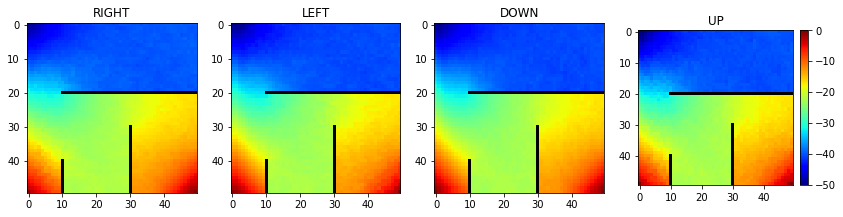

In [41]:
agent.plotQ()

<Figure size 432x288 with 0 Axes>

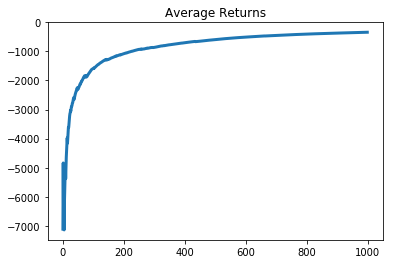

In [42]:
plt.figure()
agent.plotReturns()

Now let's have a look at the visited cells after a certain number of iterations

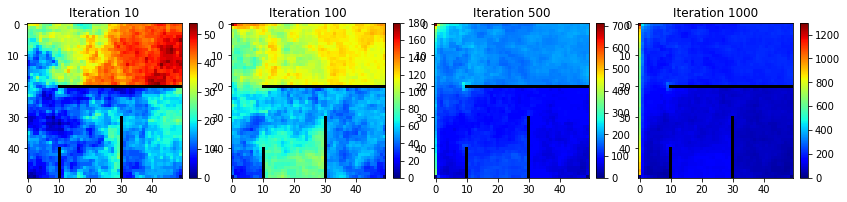

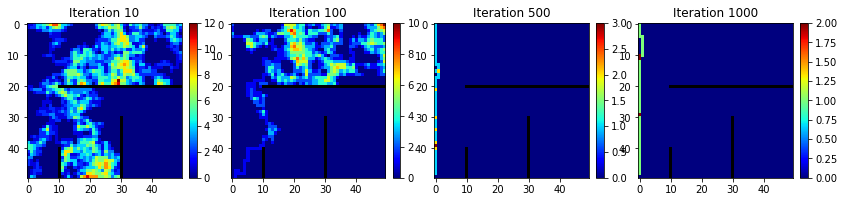

In [43]:
def runAndShowVisits(agent, iterations, totalVisits=True):
    agent.initialize()
    fig, axes = plt.subplots(nrows=1, ncols=len(iterations), figsize=(14, 14))
    total = 0
    for idx, num_iter in enumerate(iterations):
        agent.train(num_iter - 1, reset=False)
        total += num_iter

        ax = axes[idx]
        ax.set_title("Iteration {}".format(total))
        
        agent.runOnce(greedy=False)
        im = agent.toImage(agent.total_visits if totalVisits else agent.visits)
        cmap = mpl.cm.get_cmap()
        cmap.set_bad(color='black')
        im = ax.imshow(im, interpolation='nearest')    
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        plt.colorbar(im, cax=cax)
    plt.show()
    
runAndShowVisits(agent, iterations=[10, 90, 400, 500], totalVisits=True)
runAndShowVisits(agent, iterations=[10, 90, 400, 500], totalVisits=False)

## Stochastic Grid Worlds

Let's make the transitions between states stochastic. For instance, to implement a speed, we decide to add some stochasticity, by moving in the wanted direction with a given probability and to stay at the same place otherwise.

In [29]:
class StochasticGridWorld(GridWorld):
    def __init__(self, num_rows, num_cols):
        super().__init__(num_rows, num_cols)
        self.probas = np.ones(self.num_cells)
        
    def copyGrid(self, other):
        self.grid = np.copy(other.grid)
        
    def move(self, m: str):
        if random.random() < self.probas[self.position]:
            return super().move(m)
        return False
        
    def addProbas(self, positions, value):
        for i, j in positions:
            k = self.index(i, j)
            self.probas[k] = value

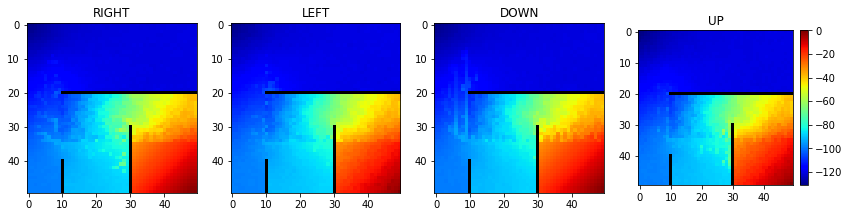

In [35]:
sgw = StochasticGridWorld(gw.num_rows, gw.num_cols)
sgw.copyGrid(gw)
stuck_proba = 0.7
for j in range(15):
    sgw.addProbas([(20 + j, i) for i in range(10, 50)], 1 - stuck_proba)

agent2 = Agent(sgw, learning_rate=0.5, epsilon=0.1, gamma=1.0)
agent2.train(num_iter=800)
agent2.plotQ()

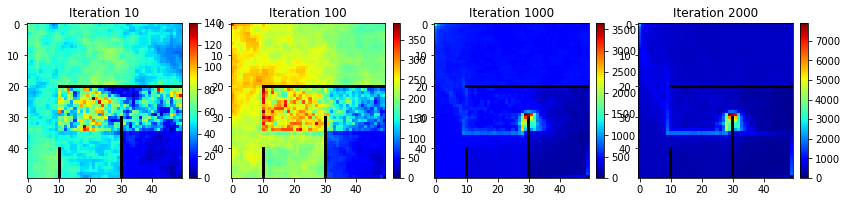

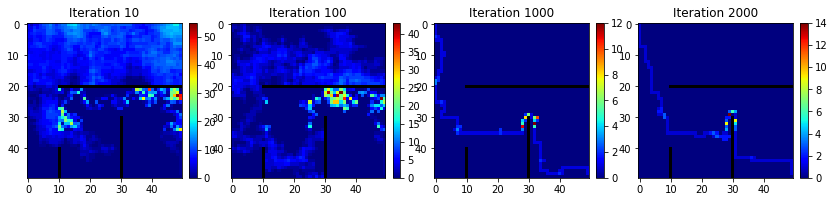

In [36]:
runAndShowVisits(agent2, iterations=[10, 90, 900, 1000], totalVisits=True)
runAndShowVisits(agent2, iterations=[10, 90, 900, 1000], totalVisits=False)